# Healthcare Insurance Premium Prediction  
### Notebook 05b — Model Training for Young Segment (Age ≤ 25)

This notebook trains the first dedicated model for the young population, based on the original feature set.

#### **Key Steps**
- Train and evaluate standard models on the young dataset  
- Identify persistent error patterns  
- Confirm that existing features do not adequately explain premium variance  
- Flag the need for additional data for improved performance

This notebook establishes the baseline young-segment model before retraining with the new *genetical_risk* feature.

In [1]:
# Import necessary libraries
from imports import *

## Data Preparation and Exploration

In [2]:
# Import the dataset and display the first few rows

df_young = pd.read_excel("../data/processed/premiums_young.xlsx")

print("Number of rows and columns: ", df_young.shape)

print("First few rows of the dataset:")
df_young.head(3)

Number of rows and columns:  (20096, 13)
First few rows of the dataset:


,Age,Gender,Region,Marital_status,Number Of Dependants,BMI_Category,Smoking_Status,Employment_Status,Income_Level,Income_Lakhs,Medical History,Insurance_Plan,Annual_Premium_Amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857


In [3]:
# Clean column names for consistency (replace spaces, lowercase all)

df_young.columns = df_young.columns.str.replace(' ', '_').str.lower()
df_young.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050


## Handling Missing Values

In [4]:
## Handling Missing Values# Check for any missing values in the dataset and handle them appropriately
print("Missing values in the dataset:")
print(df_young.isna().sum())

Missing values in the dataset:
age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           2
employment_status        1
income_level             4
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64


In [5]:
# Drop rows with missing values
df_young.dropna(inplace=True)

In [6]:
print("Missing values in the dataset:")
print(df_young.isna().sum())

Missing values in the dataset:
age                      0
gender                   0
region                   0
marital_status           0
number_of_dependants     0
bmi_category             0
smoking_status           0
employment_status        0
income_level             0
income_lakhs             0
medical_history          0
insurance_plan           0
annual_premium_amount    0
dtype: int64


## Checking for Duplicate Records

In [7]:
## Checking for Duplicate Records# Check for any duplicate values in the dataset and handle them appropriately
print("Duplicate values in the dataset:")
print(df_young.duplicated().sum())

# if duplicate values are found:
df_young.drop_duplicates(inplace=True)
print("Duplicate values in the dataset:")
print(df_young.duplicated().sum())

Duplicate values in the dataset:
0
Duplicate values in the dataset:
0


## Summary Statistics of Numerical Features

In [8]:
## Summary Statistics of Numerical Features# Generate quick summary statistics for all numeric columns
df_young.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.718019,22.510851,8142.096267
std,2.294052,0.940713,23.420493,2749.906347
min,18.000000,-3.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


### Investigating Invalid Values in 'number_of_dependants'

In [9]:
# Check for invalid dependant counts (negative values)
print(df_young[df_young.number_of_dependants<0]['number_of_dependants'].unique())
print(df_young[df_young.number_of_dependants<0].shape)

[-3 -1]
(22, 13)


In [10]:
# Correct negative dependant counts by taking absolute values
df_young['number_of_dependants'] = abs(df_young['number_of_dependants'])

# Verifying the updated distribution
df_young['number_of_dependants'].describe()

count    20090.000000
mean         0.722598
std          0.937200
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: number_of_dependants, dtype: float64

### Outlier Detection

In [11]:
# Extract all numeric columns (integers and floats)
numeric_columns_young = df_young.select_dtypes(['float64', 'int64']).columns
numeric_columns_young

Index(['age', 'number_of_dependants', 'income_lakhs', 'annual_premium_amount'], dtype='object')

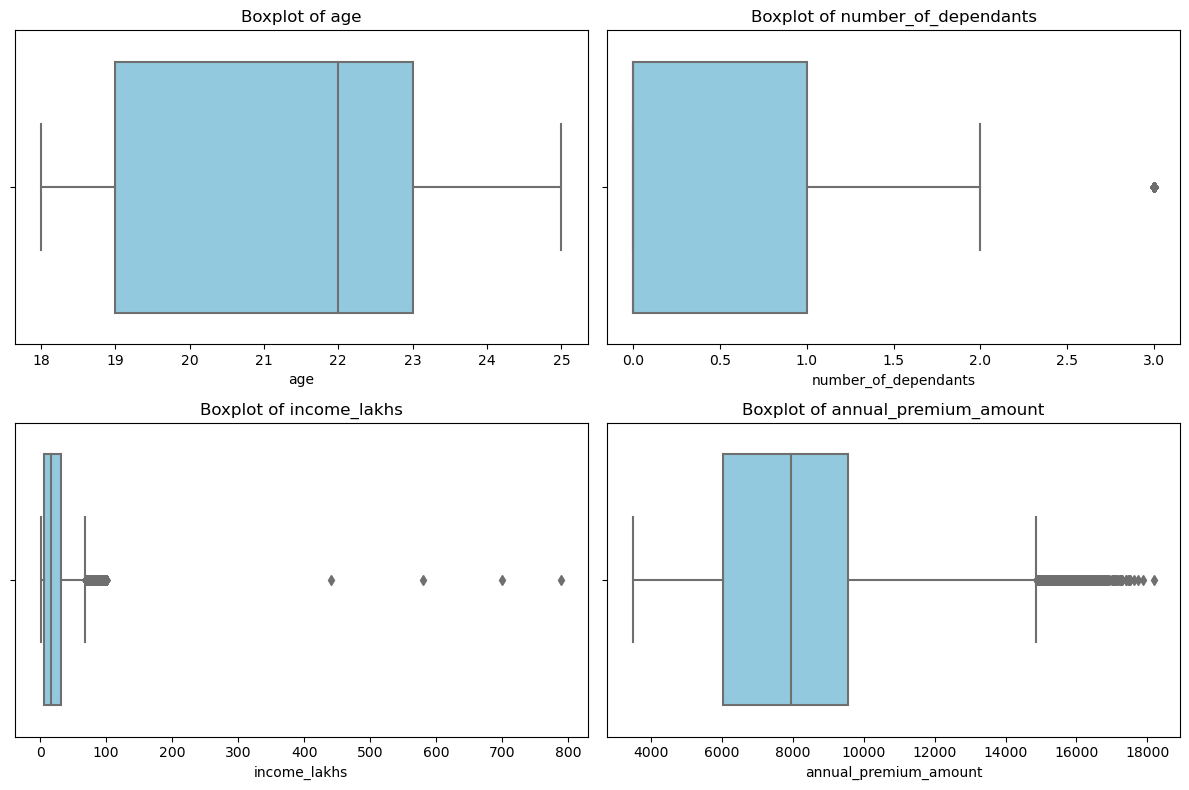

In [12]:
# Visualize outliers for all numeric columns using boxplots
# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2 rows, 2 columns
axes = axes.flatten()  # flatten so we can loop easily

for i, col in enumerate(numeric_columns_young):
    sns.boxplot(x=df_young[col], ax=axes[i], color='skyblue')
    axes[i].set_title(f"Boxplot of {col}")
    axes[i].set_xlabel(col)

plt.tight_layout()
plt.savefig("../outputs/figures/premiums_young/numeric_boxplots_grid.png", dpi=300)
plt.show()

### Outlier Treatment

#### For Age:

In [13]:
### Outlier Treatment#### For Age:# Identify unrealistic age values (>100)
print(df_young[df_young.age>100]['age'].shape)
print(df_young[df_young.age>100]['age'].unique())

(0,)
[]


In [14]:
# Drop these outliers
# Storing the cleaned data in a new DataFrame for reproducibility
df1_young = df_young[df_young.age<=100].copy()

# Verify the cleaned data
df1_young.describe()

,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20090.000000,20090.000000,20090.000000,20090.000000
mean,21.494375,0.722598,22.510851,8142.096267
std,2.294052,0.937200,23.420493,2749.906347
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.250000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,790.000000,18186.000000


#### For Income:

In [15]:
# Define a function to compute IQR bounds
def get_iqr_bounds(col):
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Check IQR-based bounds
lower, upper = get_iqr_bounds(df1_young['income_lakhs'])
print(f"IQR bounds: lower={lower}, upper={upper}")

IQR bounds: lower=-31.5, upper=68.5


In [16]:
# using quantile thresholds
for q in [0.9, 0.99, 0.999]:
    print(f"{int(q*100)}th percentile:", df1_young['income_lakhs'].quantile(q))

90th percentile: 51.0
99th percentile: 95.0
99th percentile: 100.0


In [17]:
# Set an upper threshold of 100L (≈₹1 crore) as the cutoff
quantile_threshold = 100
print("Records above threshold:", df1_young[df1_young['income_lakhs'] > quantile_threshold].shape)

Records above threshold: (4, 13)


In [18]:
# Display high-income outlier records (for reference)
high_income_outliers_young = df1_young[df1_young['income_lakhs'] > quantile_threshold]
display(high_income_outliers_young)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount
1677,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,> 40L,440,No Disease,Silver,10636
4311,20,Female,Southwest,Unmarried,0,Normal,No Smoking,Freelancer,> 40L,580,Thyroid,Silver,12888
4661,21,Female,Southwest,Unmarried,0,Obesity,No Smoking,Freelancer,> 40L,700,No Disease,Bronze,7424
6251,21,Female,Southeast,Unmarried,0,Normal,Occasional,Salaried,> 40L,790,No Disease,Silver,7586


## Distribution Analysis for Numerical Features:

In [19]:
## Distribution Analysis for Numerical Features:# Drop extreme high-income outliers and save to a new dataframe
df2_young = df1_young[df1_young['income_lakhs'] <= quantile_threshold].copy()

# Verify shape and descriptive stats post-cleaning
print("Cleaned dataset shape:", df2_young.shape)
df2_young.describe()

Cleaned dataset shape: (20086, 13)


,age,number_of_dependants,income_lakhs,annual_premium_amount
count,20086.000000,20086.000000,20086.000000,20086.000000
mean,21.494474,0.722742,22.390371,8141.799263
std,2.294248,0.937238,21.732062,2749.912486
min,18.000000,0.000000,1.000000,3501.000000
25%,19.000000,0.000000,6.000000,6022.000000
50%,22.000000,0.000000,16.000000,7939.000000
75%,23.000000,1.000000,31.000000,9561.000000
max,25.000000,3.000000,100.000000,18186.000000


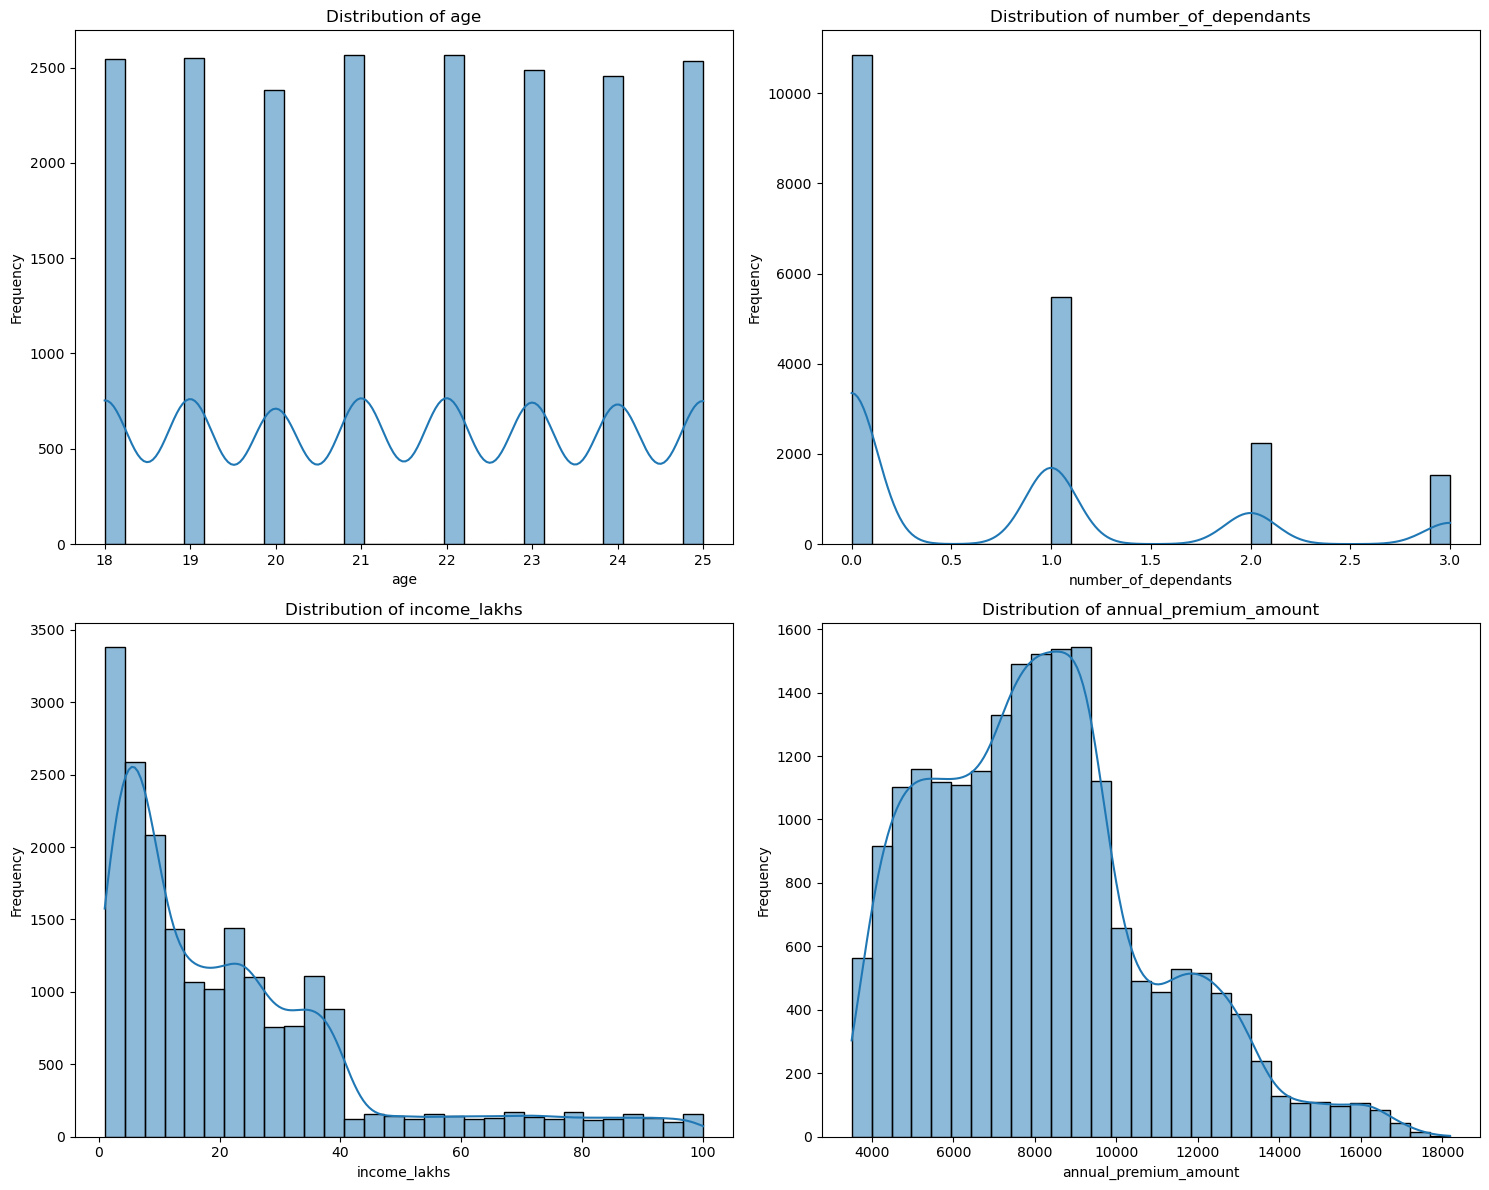

In [20]:
# Plot histograms for all numeric columns to examine data distribution and skewness
plt.figure(figsize=(15,12))

for i, col in enumerate(numeric_columns_young, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df2_young[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.savefig("../outputs/figures/premiums_young/numeric_univariate_distribution_grid.png", dpi=300)
plt.show()

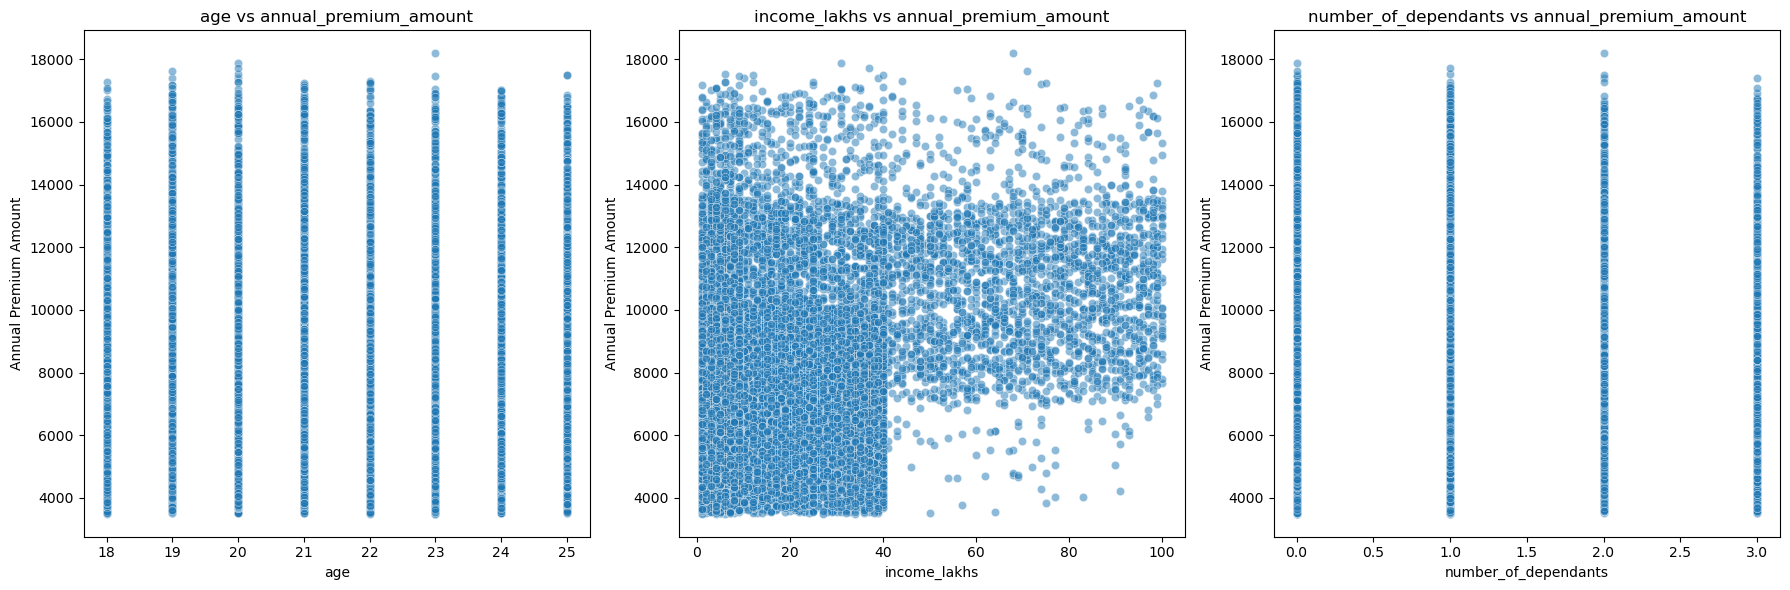

In [21]:
# Scatter plot grid to examine relationships between numeric features and annual premium
plt.figure(figsize=(18, 6))

numeric_features = ['age', 'income_lakhs', 'number_of_dependants']

for i, col in enumerate(numeric_features, 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(x=df2_young[col], y=df2_young['annual_premium_amount'], alpha=0.5)
    plt.title(f'{col} vs annual_premium_amount')
    plt.xlabel(col)
    plt.ylabel('Annual Premium Amount')

plt.tight_layout()
plt.savefig("../outputs/figures/premiums_young/numeric_bivariate_scatter_grid.png", dpi=300)
plt.show()

## Distribution Analysis for Categorical Features:

In [22]:
## Distribution Analysis for Categorical Features:# Select categorical columns
categorical_columns = df2_young.select_dtypes(['object']).columns
# Check unique values in categorical columns to identify inconsistencies
for col in categorical_columns:
    print(col, ":", df2_young[col].unique())

gender : ['Male' 'Female']
region : ['Northeast' 'Northwest' 'Southeast' 'Southwest']
marital_status : ['Unmarried' 'Married']
bmi_category : ['Overweight' 'Underweight' 'Normal' 'Obesity']
smoking_status : ['Regular' 'No Smoking' 'Occasional' 'Smoking=0' 'Does Not Smoke'
 'Not Smoking']
employment_status : ['Self-Employed' 'Freelancer' 'Salaried']
income_level : ['> 40L' '<10L' '10L - 25L' '25L - 40L']
medical_history : ['High blood pressure' 'No Disease' 'Diabetes & High blood pressure'
 'Diabetes & Heart disease' 'Diabetes' 'Diabetes & Thyroid'
 'Heart disease' 'Thyroid' 'High blood pressure & Heart disease']
insurance_plan : ['Silver' 'Bronze' 'Gold']


In [23]:
# Standardizing inconsistent 'smoking_status' entries
# Merge multiple variants representing non-smokers into a single label: 'No Smoking'
df2_young['smoking_status'].replace({
    'Smoking=0': 'No Smoking',
    'Not Smoking': 'No Smoking',
    'Does Not Smoke': 'No Smoking'
}, inplace=True)

# Verifying that values are now consistent
df2_young['smoking_status'].unique()

array(['Regular', 'No Smoking', 'Occasional'], dtype=object)

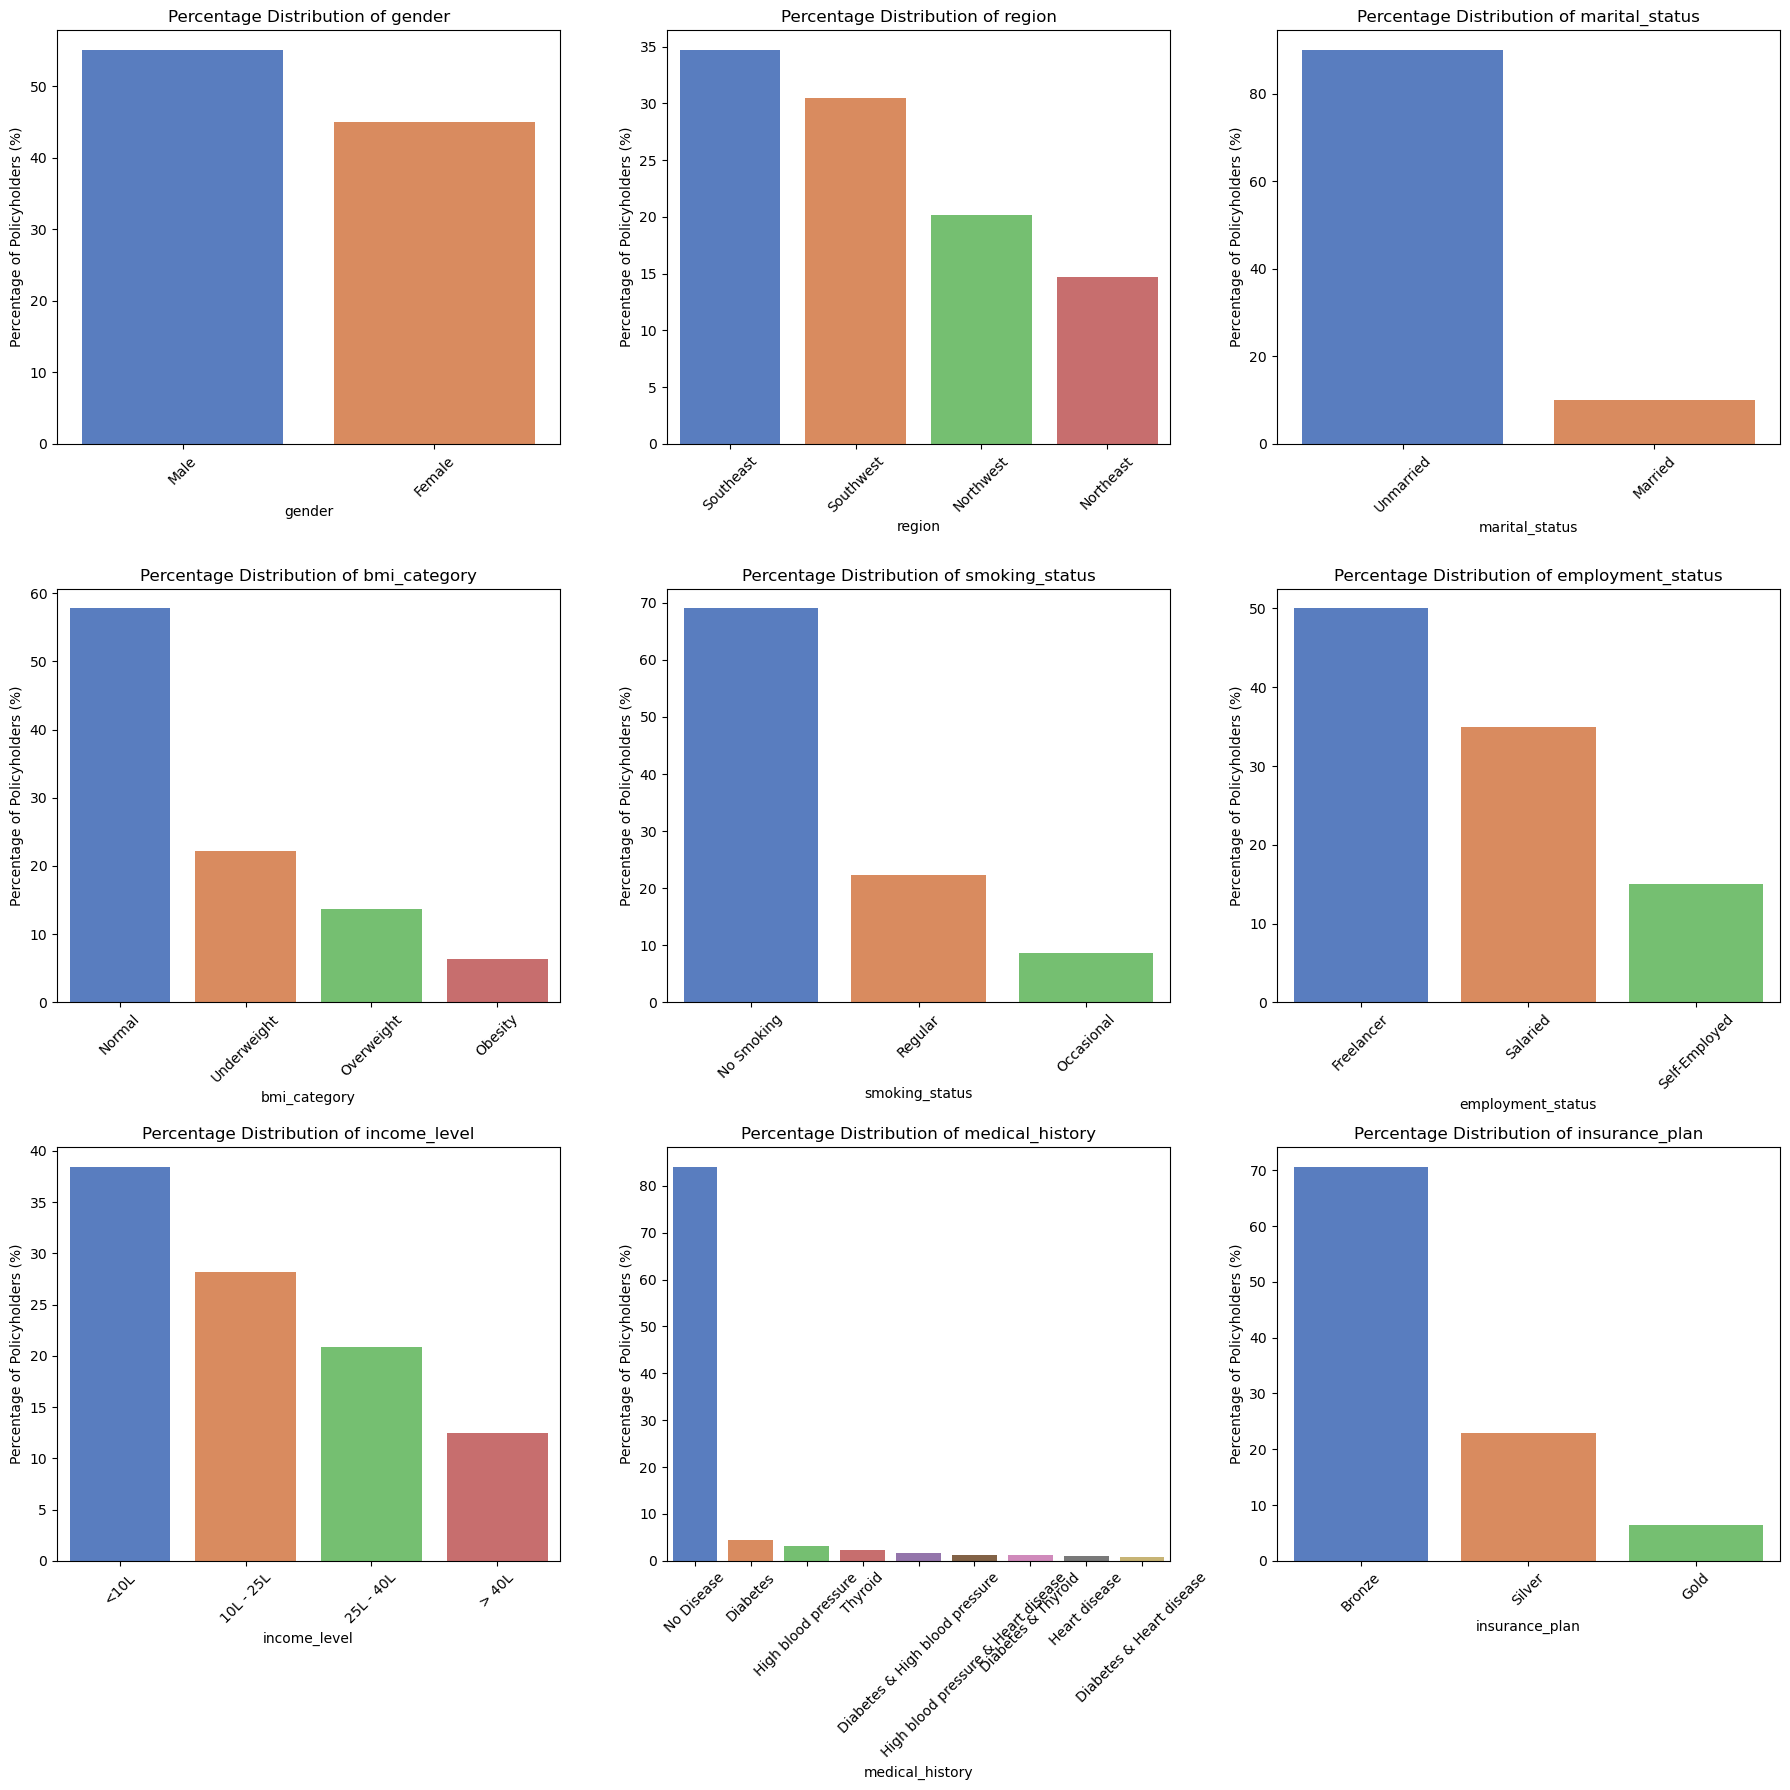

In [24]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
axes = axes.flatten()

for i, col in enumerate(categorical_columns):
    category_counts = df2_young[col].value_counts(normalize=True) * 100
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=axes[i], palette='muted')
    axes[i].set_title(f'Percentage Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Percentage of Policyholders (%)')
    axes[i].tick_params(axis='x', rotation=45)
    
plt.tight_layout()
plt.savefig("../outputs/figures/premiums_young/categorical_univariate_distribution_grid.png", dpi=300)
plt.show()

insurance_plan  Bronze  Gold  Silver
income_level                        
10L - 25L         4508   326     828
25L - 40L         3382   209     608
<10L              6172   404    1145
> 40L              115   366    2023


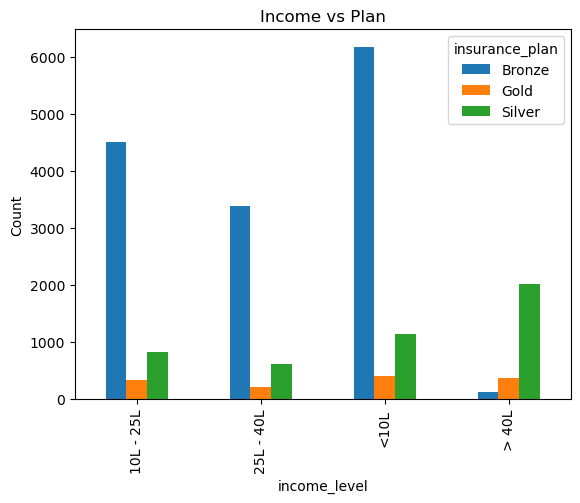

In [25]:
crosstab = pd.crosstab(df2_young['income_level'], df2_young['insurance_plan'])
print(crosstab)

crosstab.plot(kind='bar')
plt.title('Income vs Plan')
plt.ylabel('Count')
plt.savefig("../outputs/figures/premiums_young/income_vs_plan_bar.png", dpi=300)
plt.show()

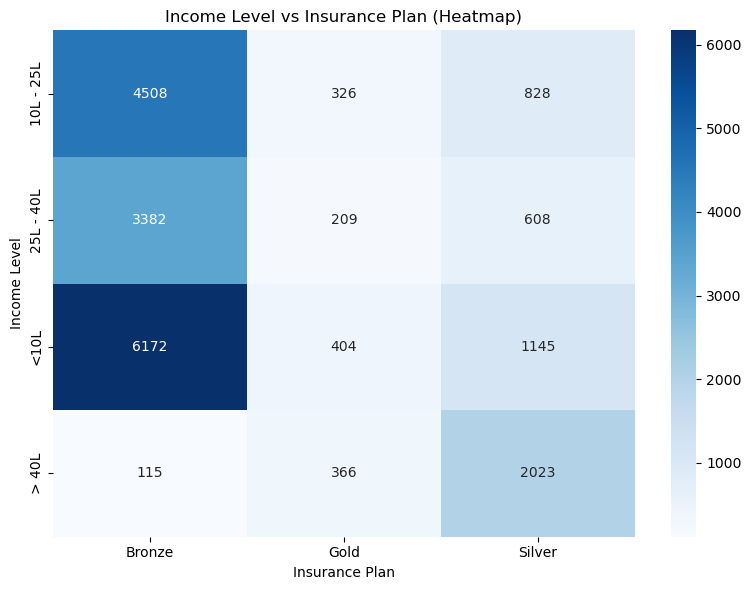

In [26]:
plt.figure(figsize=(8, 6))
sns.heatmap(crosstab, annot=True, fmt='d', cmap='Blues')
plt.title('Income Level vs Insurance Plan (Heatmap)')
plt.xlabel('Insurance Plan')
plt.ylabel('Income Level')
plt.tight_layout()
plt.savefig("../outputs/figures/premiums_young/income_vs_plan_heatmap.png", dpi=300)
plt.show()

<h2>Feature Engineering</h2>

In [27]:
df2_young.medical_history.unique()

array(['High blood pressure', 'No Disease',
       'Diabetes & High blood pressure', 'Diabetes & Heart disease',
       'Diabetes', 'Diabetes & Thyroid', 'Heart disease', 'Thyroid',
       'High blood pressure & Heart disease'], dtype=object)

In [28]:
# Define risk scores for each medical condition
# Each disease is assigned a base risk score reflecting its relative severity:
risk_scores = {
    "diabetes": 6,
    "heart disease": 8,
    "high blood pressure": 6,
    "thyroid": 5,
    "no disease": 0,
    "none": 0
}

In [29]:
# Split combined conditions (e.g., "Diabetes & Heart disease") into separate columns
# convert all text to lowercase for consistency
df2_young[['disease1', 'disease2']]= df2_young['medical_history'].str.split(" & ", expand=True).apply(lambda x: x.str.lower())

df2_young.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,None
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,None
2,21,Female,Southeast,Unmarried,0,Normal,Regular,Salaried,> 40L,97,No Disease,Silver,11857,no disease,None


In [30]:
# Replace missing entries with 'none' to handle single-condition or empty cases
df2_young['disease1'].fillna('none', inplace=True)
df2_young['disease2'].fillna('none', inplace=True)

# Initialize a new column for total risk score
df2_young['total_risk_score'] = 0

# Add up risk scores from both disease columns
for disease in ['disease1', 'disease2']:
    df2_young['total_risk_score'] += df2_young[disease].map(risk_scores)

In [31]:
# Normalize the total risk score between 0 and 1 for model compatibility
max_score = df2_young['total_risk_score'].max()
min_score = df2_young['total_risk_score'].min()

df2_young['normalized_risk_score'] = (df2_young['total_risk_score'] - min_score) / (max_score - min_score)

# Preview transformed features
df2_young.head(2)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,Overweight,Regular,Self-Employed,> 40L,99,High blood pressure,Silver,13365,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,Underweight,No Smoking,Freelancer,<10L,3,No Disease,Silver,11050,no disease,none,0,0.000000


### Ordinal Encoding for Ordered Categorical Variables

In [32]:
### Ordinal Encoding for Ordered Categorical Variables# Inspect unique values in the insurance_plan column
df2_young.insurance_plan.unique()

array(['Silver', 'Bronze', 'Gold'], dtype=object)

In [33]:
# Encode ordinal relationship: Bronze < Silver < Gold
df2_young['insurance_plan'] = df2_young['insurance_plan'].map({
    'Bronze': 1, 'Silver': 2, 'Gold': 3
})

# Verify encoded values
df2_young.insurance_plan.unique()

array([2, 1, 3])

In [34]:
# Encode ascending income levels
df2_young['income_level'] = df2_young['income_level'].map({
    '<10L': 1, '10L - 25L': 2, '25L - 40L': 3,'> 40L': 4 
})

In [35]:
# Inspect unique values in the bmi_category column
df2_young['bmi_category'].unique()

array(['Overweight', 'Underweight', 'Normal', 'Obesity'], dtype=object)

In [36]:
# Encode ascending bmi categories
df2_young['bmi_category'] = df2_young['bmi_category'].map({
    'Underweight': 1, 'Normal': 2, 'Overweight': 3,'Obesity': 4 
})

In [37]:
# Preview the updated dataset
df2_young.head(3)

,age,gender,region,marital_status,number_of_dependants,bmi_category,smoking_status,employment_status,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,total_risk_score,normalized_risk_score
0,18,Male,Northeast,Unmarried,0,3,Regular,Self-Employed,4,99,High blood pressure,2,13365,high blood pressure,none,6,0.428571
1,22,Female,Northwest,Unmarried,0,1,No Smoking,Freelancer,1,3,No Disease,2,11050,no disease,none,0,0.000000
2,21,Female,Southeast,Unmarried,0,2,Regular,Salaried,4,97,No Disease,2,11857,no disease,none,0,0.000000


### One-Hot Encoding for Nominal Categorical Variables 

In [38]:
### One-Hot Encoding for Nominal Categorical Variables # Define nominal categorical columns for one-hot encoding
nominal_cols = ['gender', 'region', 'marital_status', 'smoking_status', 'employment_status']

# Apply one-hot encoding using pandas get_dummies
# drop_first=True → drops one column per feature to avoid multicollinearity
# dtype=int → ensures the new columns are integer (0/1) instead of boolean
df3_young = pd.get_dummies(df2_young, columns=nominal_cols, drop_first=True, dtype=int)

In [39]:
df3_young.head(3)

,age,number_of_dependants,bmi_category,income_level,income_lakhs,medical_history,insurance_plan,annual_premium_amount,disease1,disease2,...,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,3,4,99,High blood pressure,2,13365,high blood pressure,none,...,0.428571,1,0,0,0,1,0,1,0,1
1,22,0,1,1,3,No Disease,2,11050,no disease,none,...,0.000000,0,1,0,0,1,0,0,0,0
2,21,0,2,4,97,No Disease,2,11857,no disease,none,...,0.000000,0,0,1,0,1,0,1,1,0


In [40]:
# Drop redundant or intermediate columns after feature engineering
# - 'medical_history' (raw text column)
# - 'disease1' (temporary helper column)
# - 'disease2' (temporary helper column)
# - 'total_risk_score' (unscaled version of normalized score)
df4_young = df3_young.drop(['medical_history', 'disease1', 'disease2','total_risk_score'], axis=1)

# Verify the resulting dataframe
df4_young.head(3)

,age,number_of_dependants,bmi_category,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed
0,18,0,3,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,1
1,22,0,1,1,3,2,11050,0.000000,0,1,0,0,1,0,0,0,0
2,21,0,2,4,97,2,11857,0.000000,0,0,1,0,1,0,1,1,0


In [41]:
# Convert all column names to lowercase for consistency
df4_young.columns = df4_young.columns.str.lower()

# Verify the resulting dataframe
df4_young.head(3)

,age,number_of_dependants,bmi_category,income_level,income_lakhs,insurance_plan,annual_premium_amount,normalized_risk_score,gender_male,region_northwest,region_southeast,region_southwest,marital_status_unmarried,smoking_status_occasional,smoking_status_regular,employment_status_salaried,employment_status_self-employed
0,18,0,3,4,99,2,13365,0.428571,1,0,0,0,1,0,1,0,1
1,22,0,1,1,3,2,11050,0.000000,0,1,0,0,1,0,0,0,0
2,21,0,2,4,97,2,11857,0.000000,0,0,1,0,1,0,1,1,0


### Feature Correlation Analysis

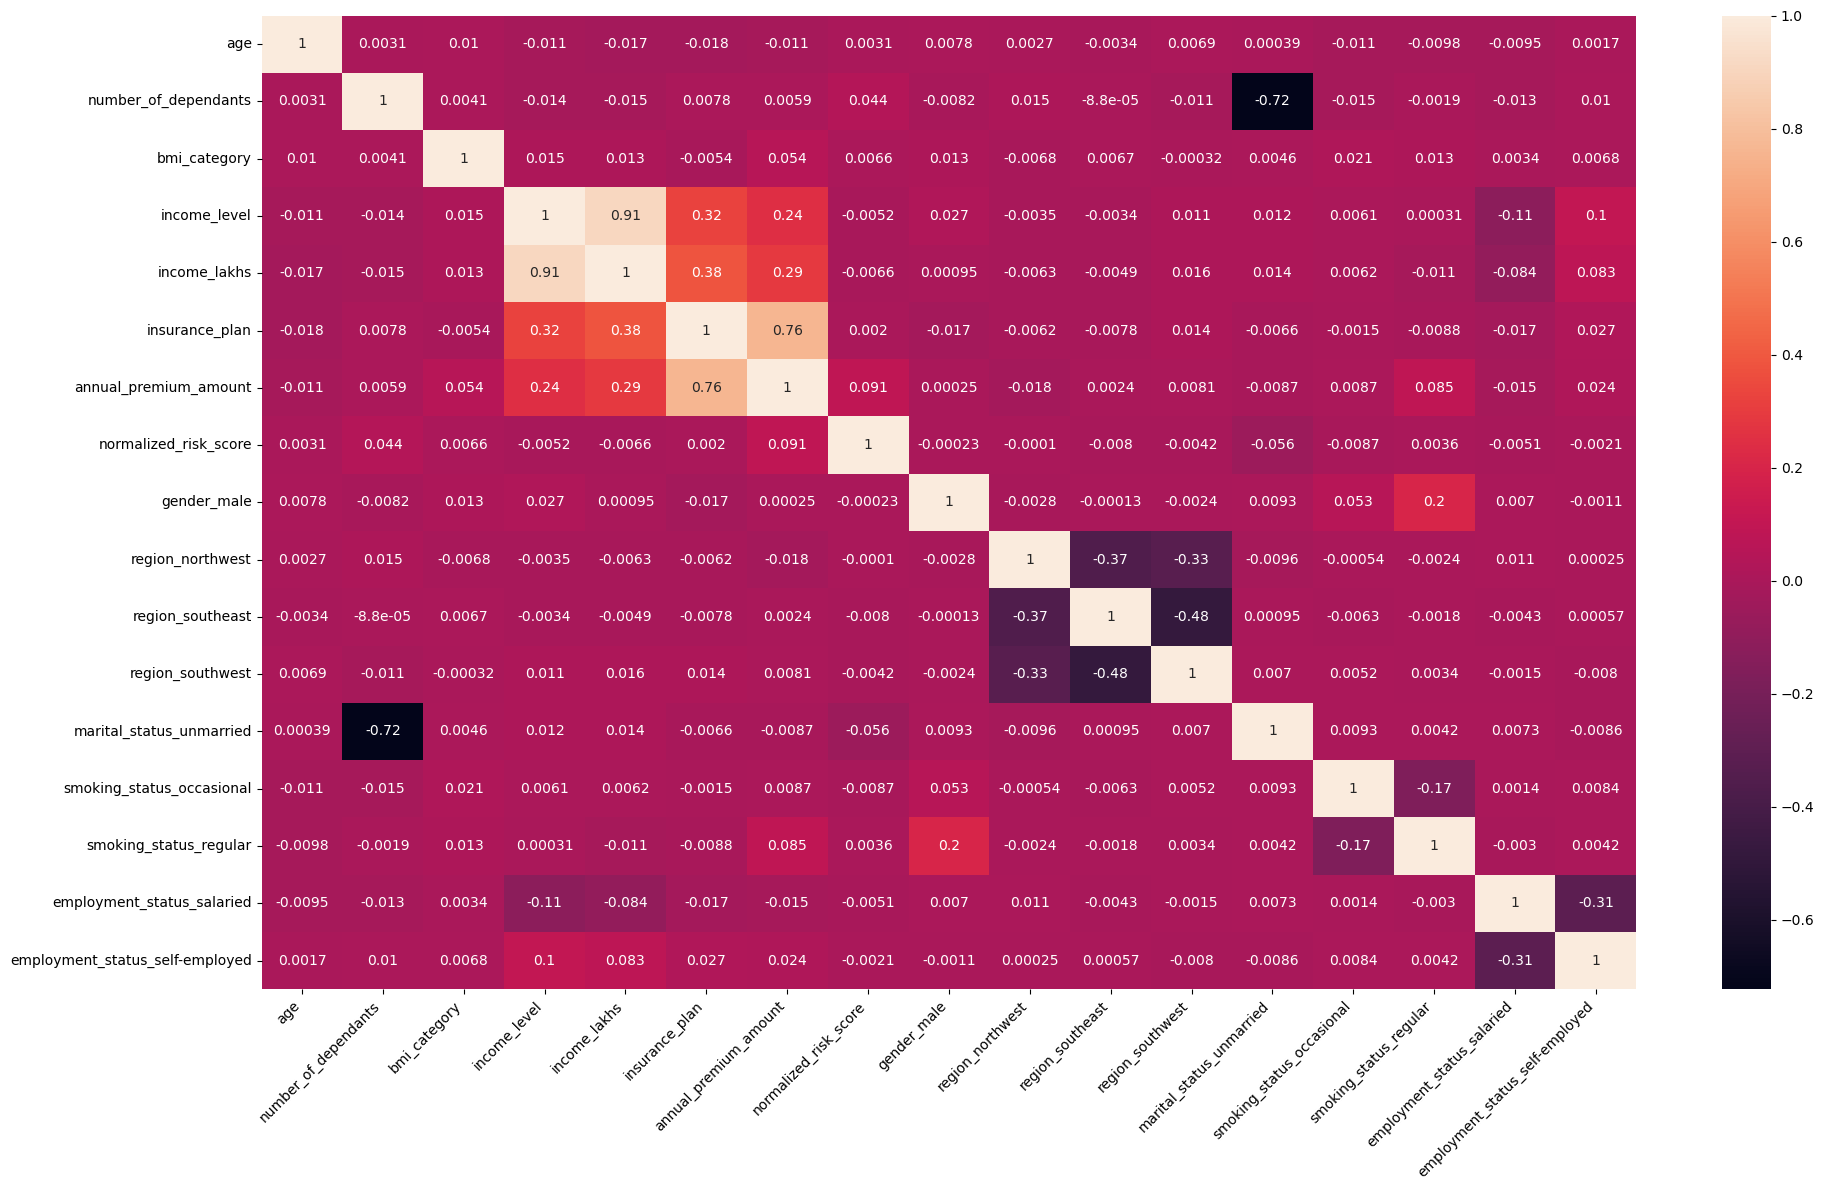

In [42]:
### Feature Correlation Analysis# Compute correlation matrix for all numerical features
cm = df4_young.corr()

# Set figure size for better readability
plt.figure(figsize=(20,12))

# Plot heatmap with correlation coefficients
sns.heatmap(cm, annot=True)

# Rotate axis labels for clarity
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Adjust layout to prevent label overlap
plt.tight_layout()

# Save figure for documentation and reproducibility
plt.savefig("../outputs/figures/premiums_young/fe_correlation_heatmap.png", dpi=300)

# Display the heatmap
plt.show()

### Feature Scaling

In [43]:
### Feature Scaling# Separate features (X) and target variable (y)
X = df4_young.drop('annual_premium_amount', axis='columns')
y = df4_young['annual_premium_amount']

# Select columns to be scaled
cols_to_scale = ['age', 'number_of_dependants', 'bmi_category', 'income_level', 'income_lakhs', 'insurance_plan']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Apply scaling to the selected columns
# This transforms all selected features to a [0, 1] range
X[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])

# Display scaled feature values for verification
X.head(4)

,age,number_of_dependants,bmi_category,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_male,region_northwest,region_southeast,region_southwest,marital_status_unmarried,smoking_status_occasional,smoking_status_regular,employment_status_salaried,employment_status_self-employed
0,0.000000,0.0,0.666667,1.000000,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,1
1,0.571429,0.0,0.000000,0.000000,0.020202,0.5,0.000000,0,1,0,0,1,0,0,0,0
2,0.428571,0.0,0.333333,1.000000,0.969697,0.5,0.000000,0,0,1,0,1,0,1,1,0
3,1.000000,0.0,0.333333,0.333333,0.141414,0.0,0.000000,1,0,1,0,1,0,0,0,0


In [44]:
X.describe()

,age,number_of_dependants,bmi_category,income_level,income_lakhs,insurance_plan,normalized_risk_score,gender_male,region_northwest,region_southeast,region_southwest,marital_status_unmarried,smoking_status_occasional,smoking_status_regular,employment_status_salaried,employment_status_self-employed
count,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000,20086.000000
mean,0.499211,0.240914,0.347024,0.357994,0.216064,0.179578,0.092076,0.550383,0.201284,0.346958,0.304590,0.899881,0.086379,0.223589,0.350045,0.149955
std,0.327750,0.312413,0.260652,0.347481,0.219516,0.300051,0.230016,0.497467,0.400970,0.476014,0.460245,0.300167,0.280929,0.416660,0.476996,0.357036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142857,0.000000,0.333333,0.000000,0.050505,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.571429,0.000000,0.333333,0.333333,0.151515,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.714286,0.333333,0.333333,0.666667,0.303030,0.500000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Multicollinearity Check using Variance Inflation Factor (VIF)

In [45]:
# Function to calculate Variance Inflation Factor (VIF)
def calculate_vif(data):
    vif_df = pd.DataFrame()
    vif_df['Column'] = data.columns
    vif_df['VIF'] = [variance_inflation_factor(data.values,i) for i in range(data.shape[1])]
    return vif_df

In [46]:
# Calculate VIF for all features
vif_before = calculate_vif(X)

# Display the initial VIF table
display(vif_before)

,Column,VIF
0,age,3.145372
1,number_of_dependants,1.894472
2,bmi_category,2.679619
3,income_level,11.929242
4,income_lakhs,11.873491
5,insurance_plan,1.592614
6,normalized_risk_score,1.154859
7,gender_male,2.298660
8,region_northwest,2.149017
9,region_southeast,2.974655


In [47]:
# Recalculate VIF after removing the redundant feature
vif_after = calculate_vif(X.drop('income_level', axis='columns'))
display(vif_after)

,Column,VIF
0,age,3.144058
1,number_of_dependants,1.892043
2,bmi_category,2.678994
3,income_lakhs,2.292963
4,insurance_plan,1.587514
5,normalized_risk_score,1.154815
6,gender_male,2.288595
7,region_northwest,2.148111
8,region_southeast,2.973509
9,region_southwest,2.734952


### Saving VIF Results

In [48]:
# Save VIF results to CSV files
vif_before.to_csv("../outputs/tables/young/vif_before_reduction.csv", index=False)
vif_after.to_csv("../outputs/tables/young/vif_after_reduction.csv", index=False)

In [49]:
# Based on results, remove 'income_level' (highly correlated with income_lakhs)
X_reduced = X.drop('income_level', axis='columns')
X_reduced.head()

,age,number_of_dependants,bmi_category,income_lakhs,insurance_plan,normalized_risk_score,gender_male,region_northwest,region_southeast,region_southwest,marital_status_unmarried,smoking_status_occasional,smoking_status_regular,employment_status_salaried,employment_status_self-employed
0,0.000000,0.000000,0.666667,0.989899,0.5,0.428571,1,0,0,0,1,0,1,0,1
1,0.571429,0.000000,0.000000,0.020202,0.5,0.000000,0,1,0,0,1,0,0,0,0
2,0.428571,0.000000,0.333333,0.969697,0.5,0.000000,0,0,1,0,1,0,1,1,0
3,1.000000,0.000000,0.333333,0.141414,0.0,0.000000,1,0,1,0,1,0,0,0,0
4,0.285714,0.666667,0.666667,0.131313,0.0,0.000000,1,0,1,0,1,0,0,0,0


In [50]:
X_reduced.shape

(20086, 15)

In [51]:
y.shape

(20086,)

# Model Training

In [52]:
# Split data into training and testing sets (70/30 split)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=10)

# Display shapes of splits for verification
print("x train: ", X_train.shape)
print("x test: ", X_test.shape)
print("y train: ", y_train.shape)
print("y test: ", y_test.shape)

x train:  (14060, 15)
x test:  (6026, 15)
y train:  (14060,)
y test:  (6026,)


## Linear Regression Model Training

In [53]:
## Linear Regression Model Training# Initialize and train the Linear Regression model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Calculate R² scores for training and testing sets
train_score = model_lr.score(X_train, y_train)
test_score = model_lr.score(X_test, y_test)

# Print the R² scores for training and testing sets
train_score, test_score

(0.5983128305292287, 0.6018778366357369)

In [54]:
y_pred_lr = model_lr.predict(X_test)

mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
print("Linear Regression:")
print("MSE:", mse_lr, "RMSE:", rmse_lr)

Linear Regression:
MSE: 3027579.480614801 RMSE: 1739.994103614952


In [55]:
# Display the model's intercept value
model_lr.intercept_

6575.084069062288

In [56]:
# Display the model's coefficients
model_lr.coef_

array([ 6.17415458e+01, -1.49861232e+02,  5.76181703e+02, -1.94970015e+01,
        6.99377694e+03,  1.10951099e+03, -1.18886491e+01, -1.13361249e+02,
       -3.05284791e+01, -6.77233134e+01, -6.66140029e+01,  2.47656361e+02,
        6.17585110e+02, -1.44093158e+01, -1.70920375e+00])

In [57]:
# Extract model coefficients as feature importance
feature_importances = model_lr.coef_

# Build a dataframe of coefficients
coef_df = pd.DataFrame(feature_importances, index=X_test.columns ,columns=['Coefficients'])

# Sort coefficients from lowest to highest
coef_df = coef_df.sort_values(by='Coefficients', ascending=True)

# Display the DataFrame
display(coef_df)

,Coefficients
number_of_dependants,-149.861232
region_northwest,-113.361249
region_southwest,-67.723313
marital_status_unmarried,-66.614003
region_southeast,-30.528479
income_lakhs,-19.497001
employment_status_salaried,-14.409316
gender_male,-11.888649
employment_status_self-employed,-1.709204
age,61.741546


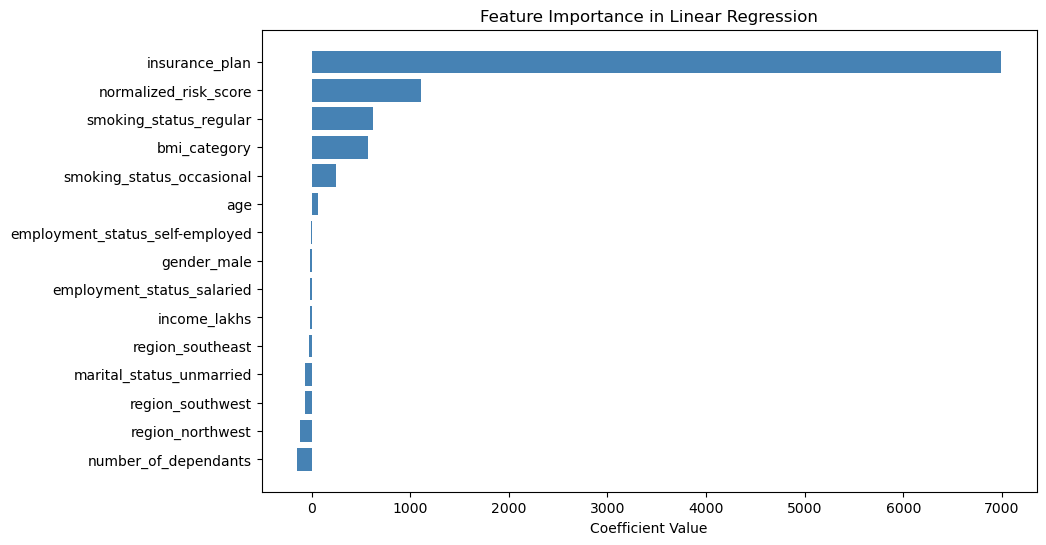

In [58]:
# Plot feature importances

plt.figure(figsize=(10,6))
plt.barh(coef_df.index, coef_df['Coefficients'], color='steelblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance in Linear Regression')
plt.savefig('../outputs/figures/premiums_young/lr_feature_importance.png', dpi=300)
plt.show()

## Ridge Regression Model Training

In [59]:
## Ridge Regression Model Training# Initialize and train the Ridge Regression model
model_rg = Ridge()
model_rg.fit(X_train, y_train)

# Calculate R² scores for training and testing sets
train_score_rg = model_rg.score(X_train, y_train)
test_score_rg = model_rg.score(X_test, y_test)

# Print the R² scores for training and testing sets
train_score_rg, test_score_rg

(0.5983123757915163, 0.6018873874257726)

In [60]:
y_pred_rg = model_rg.predict(X_test)

mse_rg = mean_squared_error(y_test, y_pred_rg)
rmse_rg = np.sqrt(mse_rg)
print("Ridge Regression:")
print("MSE:", mse_rg, "RMSE:", rmse_rg)

Ridge Regression:
MSE: 3027506.85020485 RMSE: 1739.9732326115968


## Random Forest Regression Model Training

In [61]:
## Random Forest Regression Model Training# Initialize and train the Random Forest Regression model
model_rf = RandomForestRegressor()
model_rf.fit(X_train, y_train)

# Calculate R² scores for training and testing sets
train_score_rf = model_rf.score(X_train, y_train)
test_score_rf = model_rf.score(X_test, y_test)

# Print the R² scores for training and testing sets
train_score_rf, test_score_rf

(0.9243027327724554, 0.5409414840908815)

In [62]:
y_pred_rf = model_rf.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
print("Random Forest Regression:")
print("MSE:", mse_rf, "RMSE:", rmse_rf)

Random Forest Regression:
MSE: 3490979.0789424 RMSE: 1868.4161953222306


## XGBoost Regression Model Training

In [65]:
## XGBoost Regression Model Trainingmodel_xgb = XGBRegressor()
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)

# Calculate R² scores for training and testing sets
train_score_xgb = model_xgb.score(X_train, y_train)
test_score_xgb = model_xgb.score(X_test, y_test)

# Print the R² scores for training and testing sets
train_score_xgb, test_score_xgb

(0.7255523179982791, 0.5656149207959897)

In [66]:
y_pred_xgb = model_xgb.predict(X_test)

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
print("XGBoost Regression:")
print("MSE:", mse_xgb, "RMSE:", rmse_xgb)

XGBoost Regression:
MSE: 3303346.242695888 RMSE: 1817.511002083863


### Hyperparameter Tuning for XGBoost (RandomizedSearchCV)

In [67]:
### Hyperparameter Tuning for XGBoost (RandomizedSearchCV)# Define hyperparameter search space for XGBoost
param_grid = {
    'n_estimators': [20, 40, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

# Randomized hyperparameter search (limited iterations for efficiency)
random_search = RandomizedSearchCV(
                model_xgb,
                param_grid,
                n_iter=10,
                cv=3,
                scoring='r2',
                random_state=42,
                n_jobs=-1)

# Fit search on training data
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [20, 40, 50]},
                   random_state=42, scoring='r2')

In [68]:
y_pred_xgb_cv = random_search.predict(X_test)

mse_xgb_cv = mean_squared_error(y_test, y_pred_xgb_cv)
rmse_xgb_cv = np.sqrt(mse_xgb_cv)
print("XGBoost Regression with RandomizedSearch CV:")
print("MSE:", mse_xgb_cv, "RMSE:", rmse_xgb_cv)

XGBoost Regression with RandomizedSearch CV:
MSE: 3014804.7637916454 RMSE: 1736.3193150430727


In [69]:
# Calculate R² scores for training and testing sets
train_score_xgb_cv = random_search.score(X_train, y_train)
test_score_xgb_cv = random_search.score(X_test, y_test)

# Print the R² scores for training and testing sets
train_score_xgb_cv, test_score_xgb_cv

(0.6043641752626508, 0.6035576927487027)

In [70]:
# Inspect best cross-validated score and parameters
print("Best CV R²:", random_search.best_score_)
print("Best Params:", random_search.best_params_)

Best CV R²: 0.5999811149264382
Best Params: {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1}


In [71]:
results = pd.DataFrame({
    "Model": ["Linear Regression", "Ridge Regression", "Random Forest", "XGBoost", "XGBoost_CV"],
    "Train R²": [train_score, train_score_rg, train_score_rf, train_score_xgb, train_score_xgb_cv],
    "Test R²":  [test_score, test_score_rg, test_score_rf, test_score_xgb, test_score_xgb_cv],
    "RMSE":     [rmse_lr, rmse_rg, rmse_rf, rmse_xgb, rmse_xgb_cv]
})

results

,Model,Train R²,Test R²,RMSE
0,Linear Regression,0.598313,0.601878,1739.994104
1,Ridge Regression,0.598312,0.601887,1739.973233
2,Random Forest,0.924303,0.540941,1868.416195
3,XGBoost,0.725552,0.565615,1817.511002
4,XGBoost_CV,0.604364,0.603558,1736.319315


In [72]:
results.to_csv("../outputs/tables/young/model_comparison.csv", index=False)

In [73]:
# Use the best estimator from the search as the final linear model
best_model = model_lr

The Linear Regression model showed quite an increase in the accuracy, the accuracy for the overall model was 92% but for the premium_rest data, the accuracy was 94% and the XGBoost showed an impressive accuracy of around 99%

# Error Analysis

In [74]:
# Generate predictions using the tuned model
y_pred = best_model.predict(X_test)

# Calculate raw residuals and percentage error
# diff_pct shows how far off the model is relative to actual premium
residuals = y_pred - y_test
residuals_pct = residuals*100/y_test

# Combine results into a single dataframe for easier analysis
results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'diff': residuals,
    'diff_pct': residuals_pct
})

results_df.head()

,actual,predicted,diff,diff_pct
12774,6238,6389.904404,151.904404,2.435146
14758,9462,7265.142031,-2196.857969,-23.217691
13205,5152,7182.546850,2030.546850,39.412788
14278,6988,7649.634444,661.634444,9.468152
19351,4917,6462.169593,1545.169593,31.425048


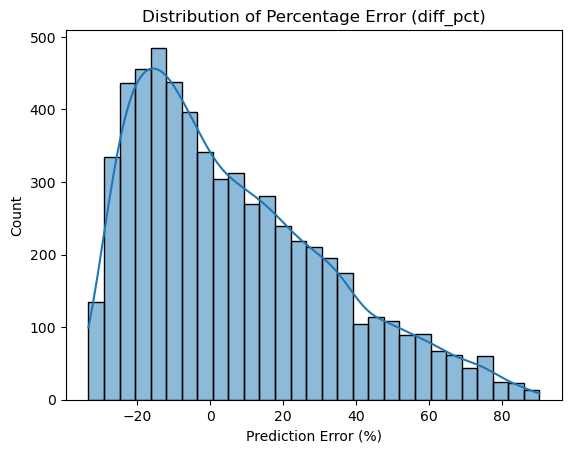

In [75]:
# Plot the distribution of percentage errors
# This reveals whether the model is consistently accurate or has dangerous outliers
sns.histplot(results_df['diff_pct'], kde=True)
plt.title("Distribution of Percentage Error (diff_pct)")
plt.xlabel("Prediction Error (%)")
plt.ylabel("Count")
plt.savefig('../outputs/figures/premiums_young/distribution_percentage_error.png', dpi=300)
plt.show()

In [76]:
# Set an error threshold (e.g., 10% is still acceptable in pricing applications)
extreme_error_threshold = 10

# Identify all predictions where the model is off by more than 10%
extreme_results_df = results_df[np.abs(results_df.diff_pct)>extreme_error_threshold]
extreme_results_df.shape

(4386, 4)

In [77]:
# Compute percentage of extreme errors
extreme_error_pct = extreme_results_df.shape[0]*100/results_df.shape[0]
extreme_error_pct

72.78460006637903

In [78]:
results_df[np.abs(results_df.diff_pct)>50].sort_values('diff_pct', ascending=False)

,actual,predicted,diff,diff_pct
3652,3536,6724.260003,3188.260003,90.165724
16580,3538,6701.032973,3163.032973,89.401723
17084,3562,6743.490651,3181.490651,89.317537
12285,3532,6672.507946,3140.507946,88.915854
4169,3517,6640.090710,3123.090710,88.799850
...,...,...,...,...
19076,5014,7527.087831,2513.087831,50.121417
1791,4331,6501.577187,2170.577187,50.117229
3613,4467,6705.221556,2238.221556,50.105699
19129,4983,7477.618375,2494.618375,50.062580


In [79]:
extreme_errors_df = X_test.loc[extreme_results_df.index]
extreme_errors_df.head()

,age,number_of_dependants,bmi_category,income_lakhs,insurance_plan,normalized_risk_score,gender_male,region_northwest,region_southeast,region_southwest,marital_status_unmarried,smoking_status_occasional,smoking_status_regular,employment_status_salaried,employment_status_self-employed
14758,0.285714,0.000000,0.333333,0.060606,0.0,0.000000,0,0,0,1,1,0,1,0,1
13205,0.714286,0.333333,0.333333,0.141414,0.0,0.000000,1,1,0,0,1,0,1,0,1
19351,0.571429,0.000000,0.000000,0.101010,0.0,0.000000,1,0,0,1,1,0,0,0,0
10622,0.428571,0.333333,0.666667,0.050505,0.0,0.357143,0,0,1,0,1,0,0,0,0
14799,0.285714,0.000000,0.333333,0.000000,0.0,1.000000,0,0,0,1,1,0,0,1,0


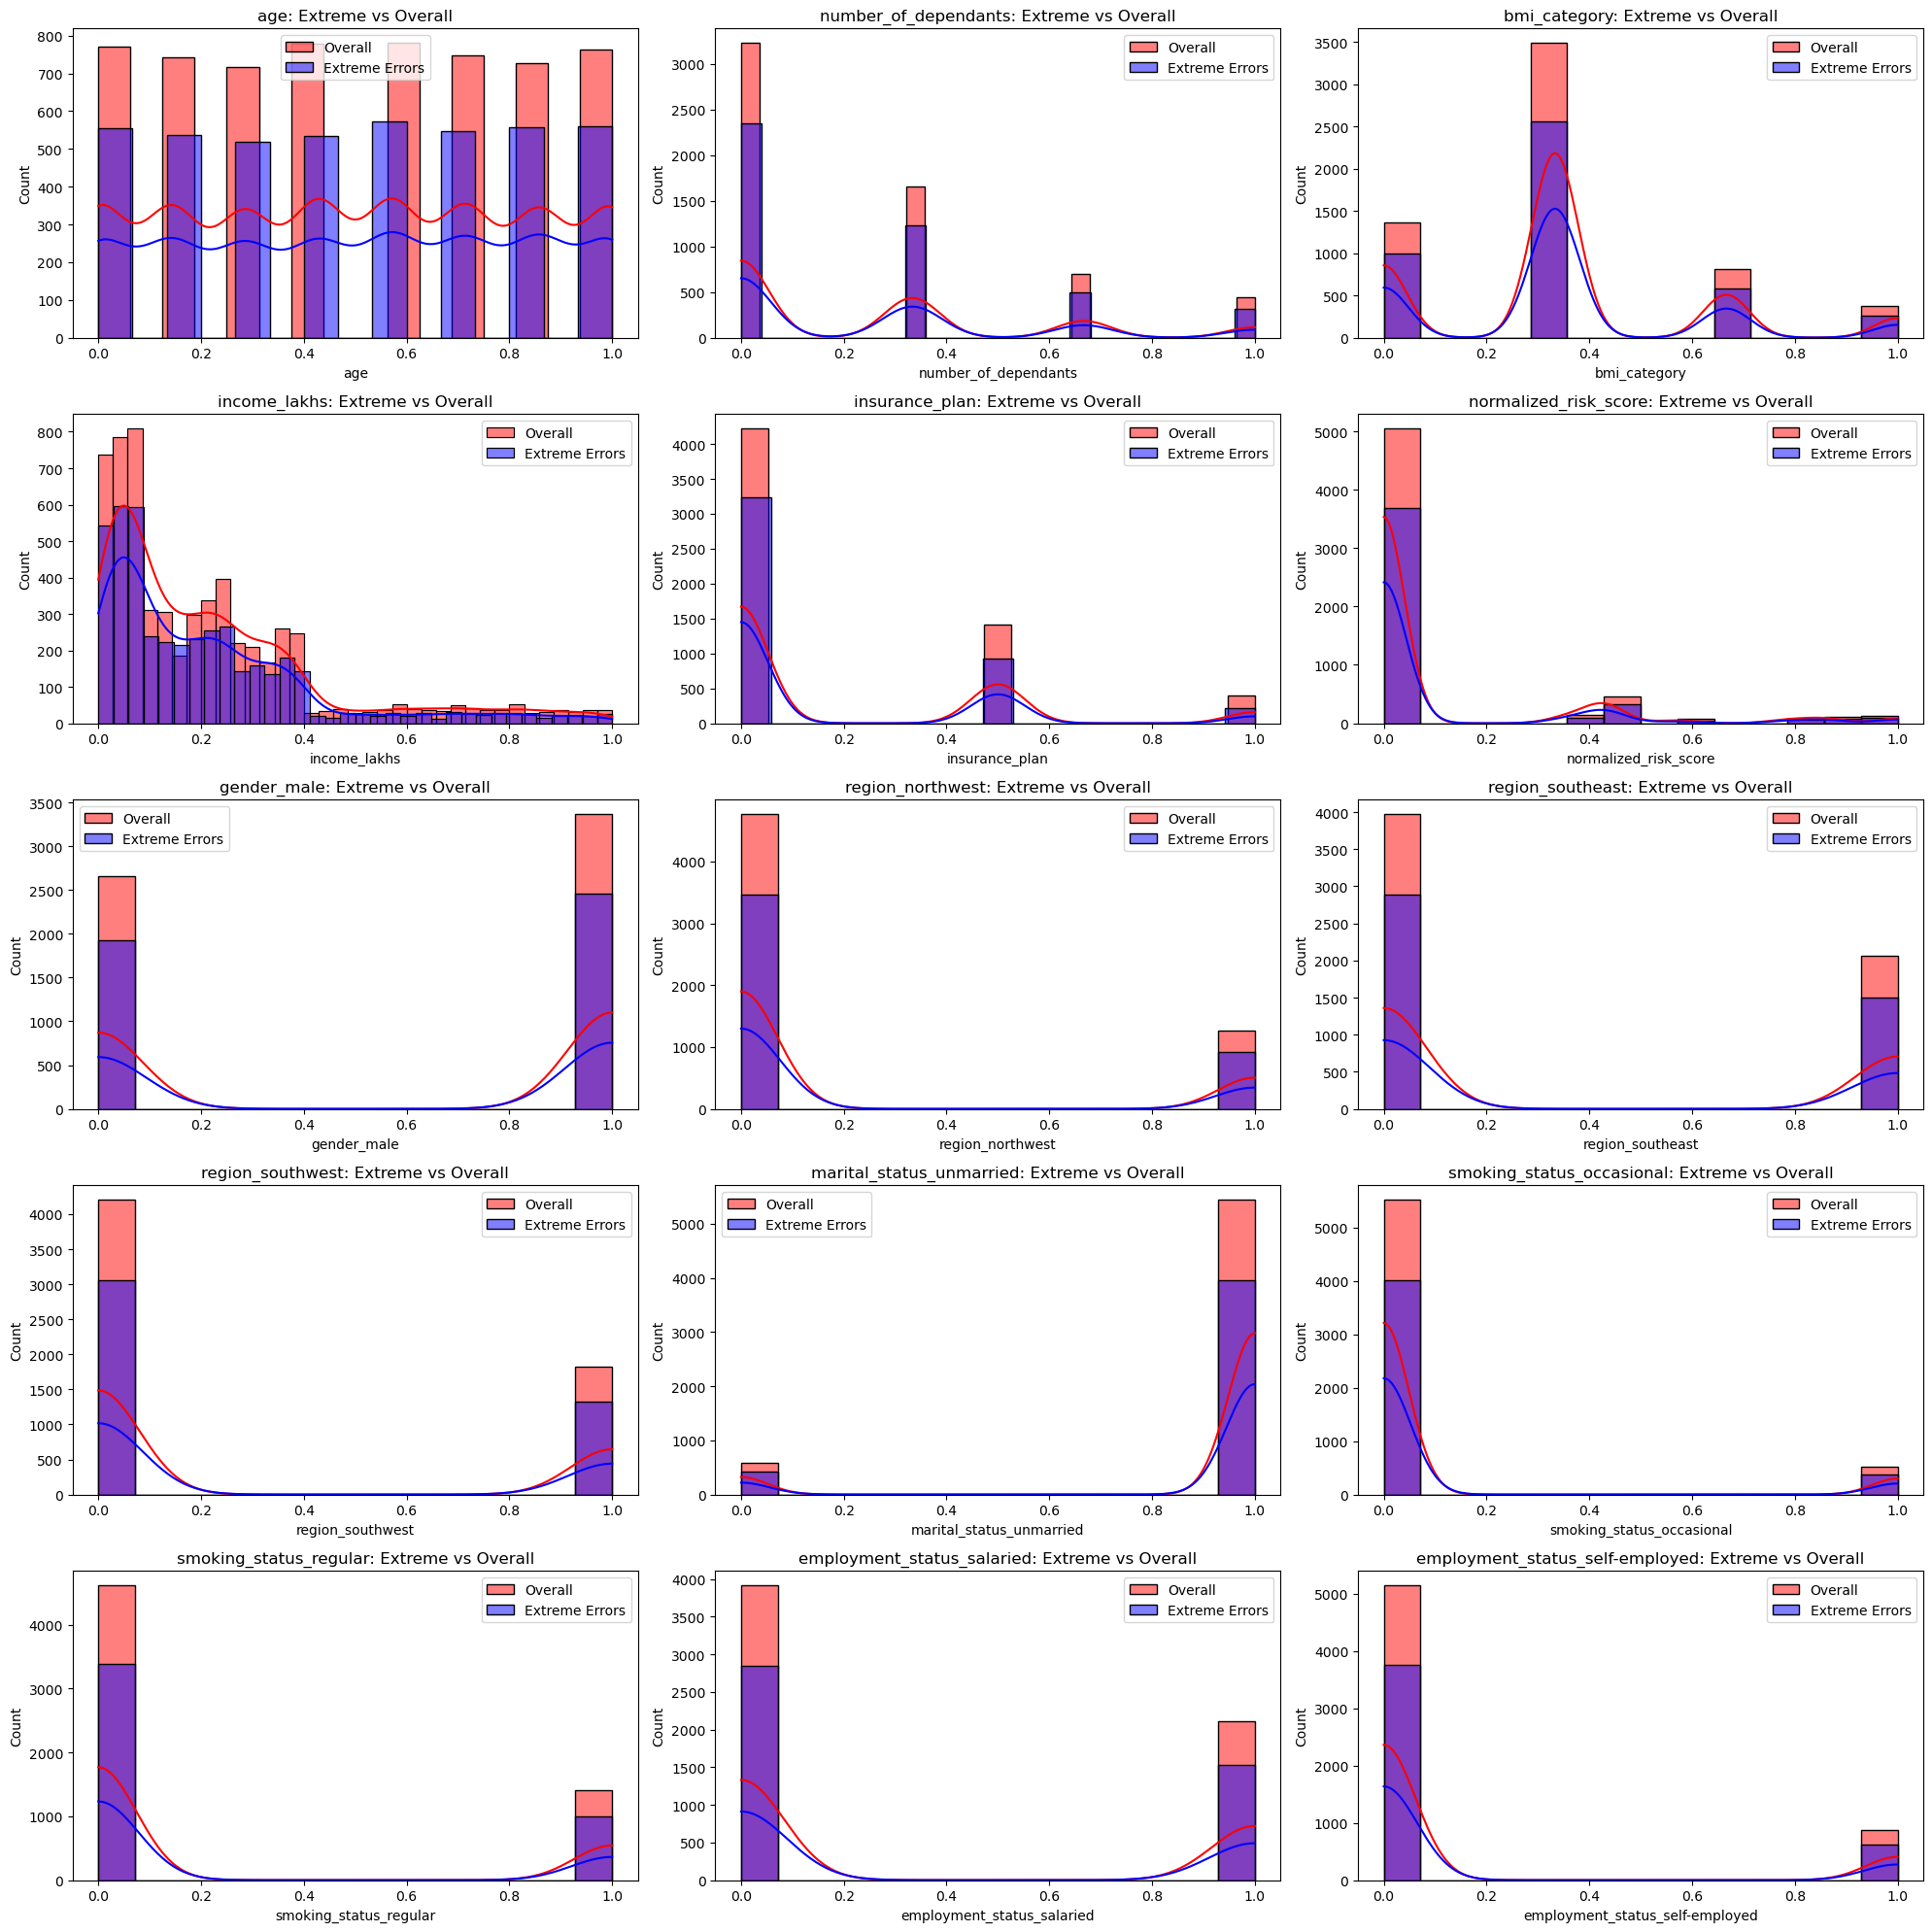

In [80]:
# Create a multi-panel figure to compare feature distributions
# for extreme-error rows vs overall test data

features = X_test.columns
n_feats = len(features)

rows = math.ceil(n_feats / 3)   # 3 plots per row
cols = 3

plt.figure(figsize=(20, rows * 4))

for i, feature in enumerate(features, 1):
    plt.subplot(rows, cols, i)
    
    # Distribution for entire test dataset
    sns.histplot(X_test[feature], label='Overall', alpha=0.5, color='red', kde=True)
    
    # Distribution for extreme error subset
    sns.histplot(extreme_errors_df[feature], label='Extreme Errors', color='blue', kde=True)
    
    plt.title(f'{feature}: Extreme vs Overall')
    plt.legend()

plt.tight_layout()
plt.savefig("../outputs/figures/premiums_young/extreme_vs_overall_distributions.png", dpi=300)
plt.show()

### Interpretation of Results for the Young Segment (Age ≤ 25)

After isolating the young customer group and training a dedicated model, the observed outcomes confirm that the high error rates previously identified are not caused by a specific subset of young customers. Instead, the issue appears to be systemic.

**1. Model Performance:**
- Linear Regression delivered the best generalization (Test R² ≈ 0.60).

- More complex models (Random Forest, XGBoost) did not improve performance.

- This indicates that the dataset lacks the complexity needed for non-linear models to add value.

**2. Error Distribution:**
- **73%** of predictions deviate by more than ±10%.

- **512** records show extreme errors greater than **50%**, which is unacceptable for deployment in real pricing systems.

**3. Feature Behavior:**

A detailed comparison of feature distributions for:

- overall young customers, 
- and those with extreme errors

revealed no meaningful differences. The errors are uniformly distributed across:

- all ages within 18–25,

- all BMI categories,

- all smoking statuses,

- all regions, and

- all employment types.

**4. Root Cause:**

Since the model cannot capture the premium variation even after segmentation, this strongly suggests:

   **The available features do not sufficiently explain premium differences for young customers.**

The model is not underfitting—it's under-informed.

**5. Recommended Next Steps:**

To reduce the extreme error rate, we can:

1. Use different feature engineering methods

2. Introduce more relevant features and retrain the model and reevaluate the error concentration and stability.